In [15]:
%load_ext autoreload
%autoreload 2

import sys
import time
sys.path.insert(0, '../')

# import embedding methods
from embedding.bernoulli import Bernoulli
from embedding.kl import KL
from embedding.matrix_factorization import MatrixFactorization

# import evaluation methods
from evaluation import evaluate_link_prediction
from evaluation import evaluate_node_classification
from evaluation import evaluate_node_clustering
# 
# import utils
from utils import graph_util
from utils import plot_util
from utils import model_util

# visualization
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Experiment 1

In [13]:
# Experiment 1

exp = {
    "max_epochs": 500,
    "learning_rate": 1e-2, #Adam
    "weight_decay": 1e-7,
    
    "link_prediction": False,
    "link_pred_num_rounds": 2,
    "link_pred_train_ratio": 0.8,
    "link_pred_eval_every_n_steps": 5,
    "link_pred_edge_emb_method": "average",
    
    "node_classification": False,
    "node_class_num_rounds": 2,
    "node_class_train_ratio": 0.8,
    "node_class_eval_every_n_steps": 5,
    
    "node_clustering": True,
    "node_clustering_num_rounds": 5,
    "node_clustering_eval_epochs": 1,
}

# pick datasets
datasets = ["cora", "citeseer", "polblogs"] # parliament, hvr, purdue_facebook

model_01 = Bernoulli(embedding_dimension=64, decoder='sigmoid')
model_02 = Bernoulli(embedding_dimension=64, decoder='gaussian')
model_03 = Bernoulli(embedding_dimension=64, decoder='exponential')

model_04 = KL(embedding_dimension=64, decoder='sigmoid', similarity_measure='adjacency')
model_05 = KL(embedding_dimension=64, decoder='exponential',similarity_measure='adjacency')
model_06 = KL(embedding_dimension=64, decoder='gaussian',similarity_measure='adjacency')
model_07 = KL(embedding_dimension=64, decoder='sigmoid',similarity_measure='laplacian')
model_08 = KL(embedding_dimension=64, decoder='exponential',similarity_measure='laplacian')
model_09 = KL(embedding_dimension=64, decoder='gaussian',similarity_measure='laplacian')
model_10 = KL(embedding_dimension=64, decoder='sigmoid', similarity_measure='dw')
model_11 = KL(embedding_dimension=64, decoder='exponential',similarity_measure='dw')
model_12 = KL(embedding_dimension=64, decoder='gaussian',similarity_measure='dw')

model_13 = MatrixFactorization(embedding_dimension=64, similarity_measure='adjacency')
model_14 = MatrixFactorization(embedding_dimension=64, similarity_measure='laplacian')
model_15 = MatrixFactorization(embedding_dimension=64, similarity_measure='dw')


embedding_methods = [model_01, model_04, model_03]

#model_01, model_03, model_04, model_06, 

# embedding_methods = [model_13, model_14, model_15]

# Normalized mutual information
total_NMI=[]

# setup folders to store experiment setup summary and results
result_folder = plot_util.setup_folders_and_summary_files(exp, datasets, embedding_methods)
print(f'The results of the current experiment are stored at experiments/{result_folder}')

for dataset in datasets:
    
    # load dataset
    A, y = graph_util.load_dataset(dataset)
    
    
    for model in embedding_methods:
        start = time.time()
        # do link prediction
        if(exp["link_prediction"]):
            link_prediction_folder = result_folder + "/link_prediction"
            evaluate_link_prediction.expLP(A,dataset,model,exp["link_pred_num_rounds"],
                                           link_prediction_folder, train_ratio=exp["link_pred_train_ratio"], 
                                           edge_emb_method=exp["link_pred_edge_emb_method"],train_epochs=exp["max_epochs"],
                                           eval_epochs=exp["link_pred_eval_every_n_steps"], undirected=True)
            
        # do node classification
        if(exp["node_classification"]):
            node_classification_folder = result_folder + "/node_classification"
            evaluate_node_classification.expNC(A,y,dataset,model,exp["node_class_num_rounds"],
                                               node_classification_folder, train_ratio=exp["node_class_train_ratio"],
                
                                               train_epochs=exp["max_epochs"],eval_epochs=exp["node_class_eval_every_n_steps"],undirected=True)
        if(exp["node_clustering"]):
            node_clustering_folder = result_folder + "/node_clustering"
            NMI = evaluate_node_clustering.exp_Node_Clustering(A,y,dataset,model,exp["node_clustering_num_rounds"],
                                           node_clustering_folder ,eval_epochs=exp["node_clustering_eval_epochs"],undirected=True)
            total_NMI.append(NMI)
            
        end = time.time()
        print(f'Model evaluation took: {end-start} seconds')

The results of the current experiment are stored at experiments/results/2020_01_06_19_01
	Node clustering evaluation has started...
Epoch    0, loss = 0.64615
[5 2 0 ... 2 2 2] [6 4 4 ... 2 0 0]
0
Epoch    0, loss = 0.64612
[5 2 0 ... 2 2 2] [5 1 3 ... 2 2 1]
1
Epoch    0, loss = 0.64612
[5 2 0 ... 2 2 2] [0 4 3 ... 0 4 4]
2
Epoch    0, loss = 0.64611
[5 2 0 ... 2 2 2] [3 3 4 ... 1 5 2]
3
Epoch    0, loss = 0.64615
[5 2 0 ... 2 2 2] [0 5 4 ... 1 5 5]
4
Model evaluation took: 4.8010008335113525 seconds
	Node clustering evaluation has started...
Epoch    0, loss = 18777990.00000
[5 2 0 ... 2 2 2] [4 3 3 ... 5 0 3]
0
Epoch    0, loss = 18776728.00000
[5 2 0 ... 2 2 2] [0 6 0 ... 6 5 5]
1
Epoch    0, loss = 18775606.00000
[5 2 0 ... 2 2 2] [3 4 1 ... 0 4 3]
2
Epoch    0, loss = 18777338.00000
[5 2 0 ... 2 2 2] [1 2 0 ... 1 3 5]
3
Epoch    0, loss = 18778824.00000
[5 2 0 ... 2 2 2] [1 2 5 ... 0 1 3]
4
Model evaluation took: 4.052565574645996 seconds
	Node clustering evaluation has started..

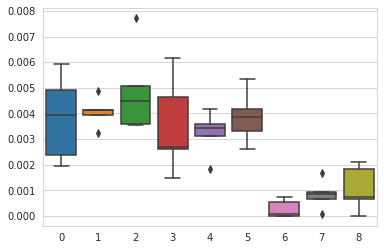

In [16]:
sns.boxplot(data= total_NMI)